# Tokyo Bus Stop Distance Analytics

Comprehensive analysis and visualization of Tokyo bus stop distances using Python data science tools.

## Import Libraries


In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from geopy.distance import geodesic
from collections import defaultdict
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

## Load and Explore Data


In [2]:
# Load the Tokyo bus stop data
with open('./data/BusstopPole.json', 'r', encoding='utf-8') as f:
    bus_data = json.load(f)

# Load the route pattern data with Japanese names
with open('./data/BusroutePattern.json', 'r', encoding='utf-8') as f:
    route_pattern_data = json.load(f)

print(f"📊 Loaded {len(bus_data):,} bus stop entries")
print(f"🛣️ Loaded {len(route_pattern_data):,} route patterns with Japanese names")
print(f"📈 Sample entry keys: {list(bus_data[0].keys())}")

📊 Loaded 3,695 bus stop entries
🛣️ Loaded 782 route patterns with Japanese names
📈 Sample entry keys: ['@id', '@type', 'title', 'dc:date', 'geo:lat', '@context', 'dc:title', 'geo:long', 'odpt:kana', 'odpt:note', 'owl:sameAs', 'odpt:operator', 'odpt:busroutePattern', 'odpt:busstopPoleNumber', 'odpt:busstopPoleTimetable']


In [3]:
# Create route ID to Japanese name mapping
route_name_mapping = {}
for route in route_pattern_data:
    route_id = route.get('owl:sameAs', '')
    japanese_name = route.get('dc:title', '')
    if route_id and japanese_name:
        route_name_mapping[route_id] = japanese_name

print(f"📋 Created mapping for {len(route_name_mapping):,} route patterns")
print("📝 Sample mappings:")
for i, (route_id, jp_name) in enumerate(list(route_name_mapping.items())[:5]):
    print(f"   {route_id.split('.')[-3]}: {jp_name}")

# Convert to DataFrame for easier analysis
def extract_bus_stop_data(stop):
    return {
        'id': stop.get('@id', ''),
        'name_ja': stop.get('title', {}).get('ja', stop.get('dc:title', '')),
        'name_en': stop.get('title', {}).get('en', ''),
        'lat': stop.get('geo:lat'),
        'lng': stop.get('geo:long'),
        'operator': stop.get('odpt:operator', [''])[0],
        'pole_number': stop.get('odpt:busstopPoleNumber', ''),
        'routes': stop.get('odpt:busroutePattern', []),
        'num_routes': len(stop.get('odpt:busroutePattern', [])),
        'last_updated': stop.get('dc:date', '')
    }

df_stops = pd.DataFrame([extract_bus_stop_data(stop) for stop in bus_data])
print(f"🚌 Created DataFrame with {len(df_stops):,} bus stops")
df_stops.head()

📋 Created mapping for 782 route patterns
📝 Sample mappings:
   Mon33: 門３３ 亀戸駅前行
   Mon33: 門３３ 豊海水産埠頭行
   Shina93: 品９３ 品川車庫前行
   Shina91: 品９１ 品川駅港南口行
   I92: 井９２ 大井町駅東口行
🚌 Created DataFrame with 3,695 bus stops


,id,name_ja,name_en,lat,lng,operator,pole_number,routes,num_routes,last_updated
0,urn:ucode:_00001C0000000000000100000322B70F,駒形橋,Komagatabashi,35.707999,139.795487,odpt.Operator:Toei,1,[odpt.BusroutePattern:Toei.Higashi42-1.52201.2...,4,2025-08-18T03:08:01+09:00
1,urn:ucode:_00001C0000000000000100000322B75E,三ノ橋,Sannohashi,35.649521,139.736965,odpt.Operator:Toei,2,"[odpt.BusroutePattern:Toei.T06.8601.2, odpt.Bu...",5,2025-08-18T03:08:01+09:00
2,urn:ucode:_00001C0000000000000100000330C11D,岩井堂,Iwaidō,35.832688,139.297021,odpt.Operator:Toei,1,"[odpt.BusroutePattern:Toei.Ume74Kou.28101.3, o...",13,2025-08-18T03:08:01+09:00
3,urn:ucode:_00001C0000000000000100000330C7A8,西葛西三丁目,Nishi-Kasai-Sanchōme (Nishi-Kasai 3),35.666064,139.855958,odpt.Operator:Toei,1,"[odpt.BusroutePattern:Toei.Shinko21.68501.1, o...",3,2025-08-18T03:08:01+09:00
4,urn:ucode:_00001C0000000000000100000330C7E8,練馬車庫前,Nerima-Shako,35.738478,139.664866,odpt.Operator:Toei,1,"[odpt.BusroutePattern:Toei.Shiro61.44102.1, od...",4,2025-08-18T03:08:01+09:00


In [4]:
# Basic statistics
print("📊 Basic Statistics:")
print(f"Total bus stops: {len(df_stops):,}")
print(f"Unique stop names: {df_stops['name_ja'].nunique():,}")
print(f"Total unique routes: {sum(len(routes) for routes in df_stops['routes']):,}")
print(f"Latitude range: {df_stops['lat'].min():.6f} to {df_stops['lat'].max():.6f}")
print(f"Longitude range: {df_stops['lng'].min():.6f} to {df_stops['lng'].max():.6f}")

# Display info about the DataFrame
df_stops.info()

📊 Basic Statistics:
Total bus stops: 3,695
Unique stop names: 1,673
Total unique routes: 15,402
Latitude range: 35.579078 to 35.839711
Longitude range: 139.183600 to 139.904000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3695 entries, 0 to 3694
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3695 non-null   object 
 1   name_ja       3695 non-null   object 
 2   name_en       3695 non-null   object 
 3   lat           3695 non-null   float64
 4   lng           3695 non-null   float64
 5   operator      3695 non-null   object 
 6   pole_number   3695 non-null   object 
 7   routes        3695 non-null   object 
 8   num_routes    3695 non-null   int64  
 9   last_updated  3695 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 288.8+ KB


## Distance Analytics Functions

In [5]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points using geodesic distance"""
    return geodesic((lat1, lon1), (lat2, lon2)).kilometers

def group_stops_by_route(df_stops):
    """Group bus stops by route patterns"""
    route_stops = defaultdict(list)
    
    for _, stop in df_stops.iterrows():
        for route in stop['routes']:
            route_stops[route].append({
                'name': stop['name_ja'],
                'lat': stop['lat'],
                'lng': stop['lng'],
                'id': stop['id']
            })
    
    return dict(route_stops)

def calculate_route_distances(route_stops):
    """Calculate distances for each route"""
    route_data = []
    
    for route_id, stops in route_stops.items():
        if len(stops) < 2:
            continue
            
        # Calculate distances between consecutive stops
        distances = []
        total_distance = 0
        
        for i in range(len(stops) - 1):
            current = stops[i]
            next_stop = stops[i + 1]
            distance = calculate_distance(
                current['lat'], current['lng'],
                next_stop['lat'], next_stop['lng']
            )
            distances.append(distance)
            total_distance += distance
        
        avg_distance = total_distance / len(distances) if distances else 0
        
        # Extract route name from ID and get Japanese name
        route_name = route_id.split(':')[1].split('.')[1] if ':' in route_id and '.' in route_id else route_id
        japanese_name = route_name_mapping.get(route_id, '')
        
        route_data.append({
            'route_id': route_id,
            'route_name': route_name,
            'route_name_ja': japanese_name,
            'num_stops': len(stops),
            'total_distance': total_distance,
            'avg_distance': avg_distance,
            'distances': distances,
            'stops': stops
        })
    
    return route_data

print("✅ Distance analytics functions defined with Japanese route names")

✅ Distance analytics functions defined with Japanese route names


## Process Route Data


In [6]:
# Group stops by routes and calculate distances
print("🔄 Processing route data...")
route_stops = group_stops_by_route(df_stops)
route_data = calculate_route_distances(route_stops)

# Convert to DataFrame for analysis
df_routes = pd.DataFrame(route_data)
print(f"📈 Processed {len(df_routes):,} routes with 2+ stops")

# Calculate overall statistics
total_routes = len(df_routes)
overall_avg_distance = df_routes['avg_distance'].mean()
total_network_distance = df_routes['total_distance'].sum()

print(f"\n📊 SUMMARY STATISTICS:")
print(f"Total routes analyzed: {total_routes:,}")
print(f"Overall average distance between stops: {overall_avg_distance:.3f} km")
print(f"Total network distance: {total_network_distance:.2f} km")

df_routes.head()

🔄 Processing route data...
📈 Processed 782 routes with 2+ stops

📊 SUMMARY STATISTICS:
Total routes analyzed: 782
Overall average distance between stops: 1.469 km
Total network distance: 27049.26 km


,route_id,route_name,route_name_ja,num_stops,total_distance,avg_distance,distances,stops
0,odpt.BusroutePattern:Toei.Higashi42-1.52201.2,Higashi42-1,東４２－１ 南千住車庫前行,22,53.578914,2.551377,"[1.8495633392214919, 0.32625959037357466, 2.77...","[{'name': '駒形橋', 'lat': 35.707999, 'lng': 139...."
1,odpt.BusroutePattern:Toei.Higashi42-1.52203.2,Higashi42-1,東４２－１ 南千住駅西口行,22,48.934012,2.330191,"[1.8495633392214919, 0.32625959037357466, 2.77...","[{'name': '駒形橋', 'lat': 35.707999, 'lng': 139...."
2,odpt.BusroutePattern:Toei.Higashi42-2.52202.2,Higashi42-2,東４２－２ 南千住車庫前行,17,26.386260,1.649141,"[1.8495633392214919, 0.32625959037357466, 2.77...","[{'name': '駒形橋', 'lat': 35.707999, 'lng': 139...."
3,odpt.BusroutePattern:Toei.Higashi42-2.52204.2,Higashi42-2,東４２－２ 南千住駅西口行,17,26.612296,1.663269,"[1.8495633392214919, 0.32625959037357466, 2.77...","[{'name': '駒形橋', 'lat': 35.707999, 'lng': 139...."
4,odpt.BusroutePattern:Toei.T06.8601.2,T06,都０６ 渋谷駅前行,25,38.325327,1.596889,"[0.8085423267251282, 0.6001558074922674, 1.481...","[{'name': '三ノ橋', 'lat': 35.649521, 'lng': 139...."


## Data Visualization & Analytics

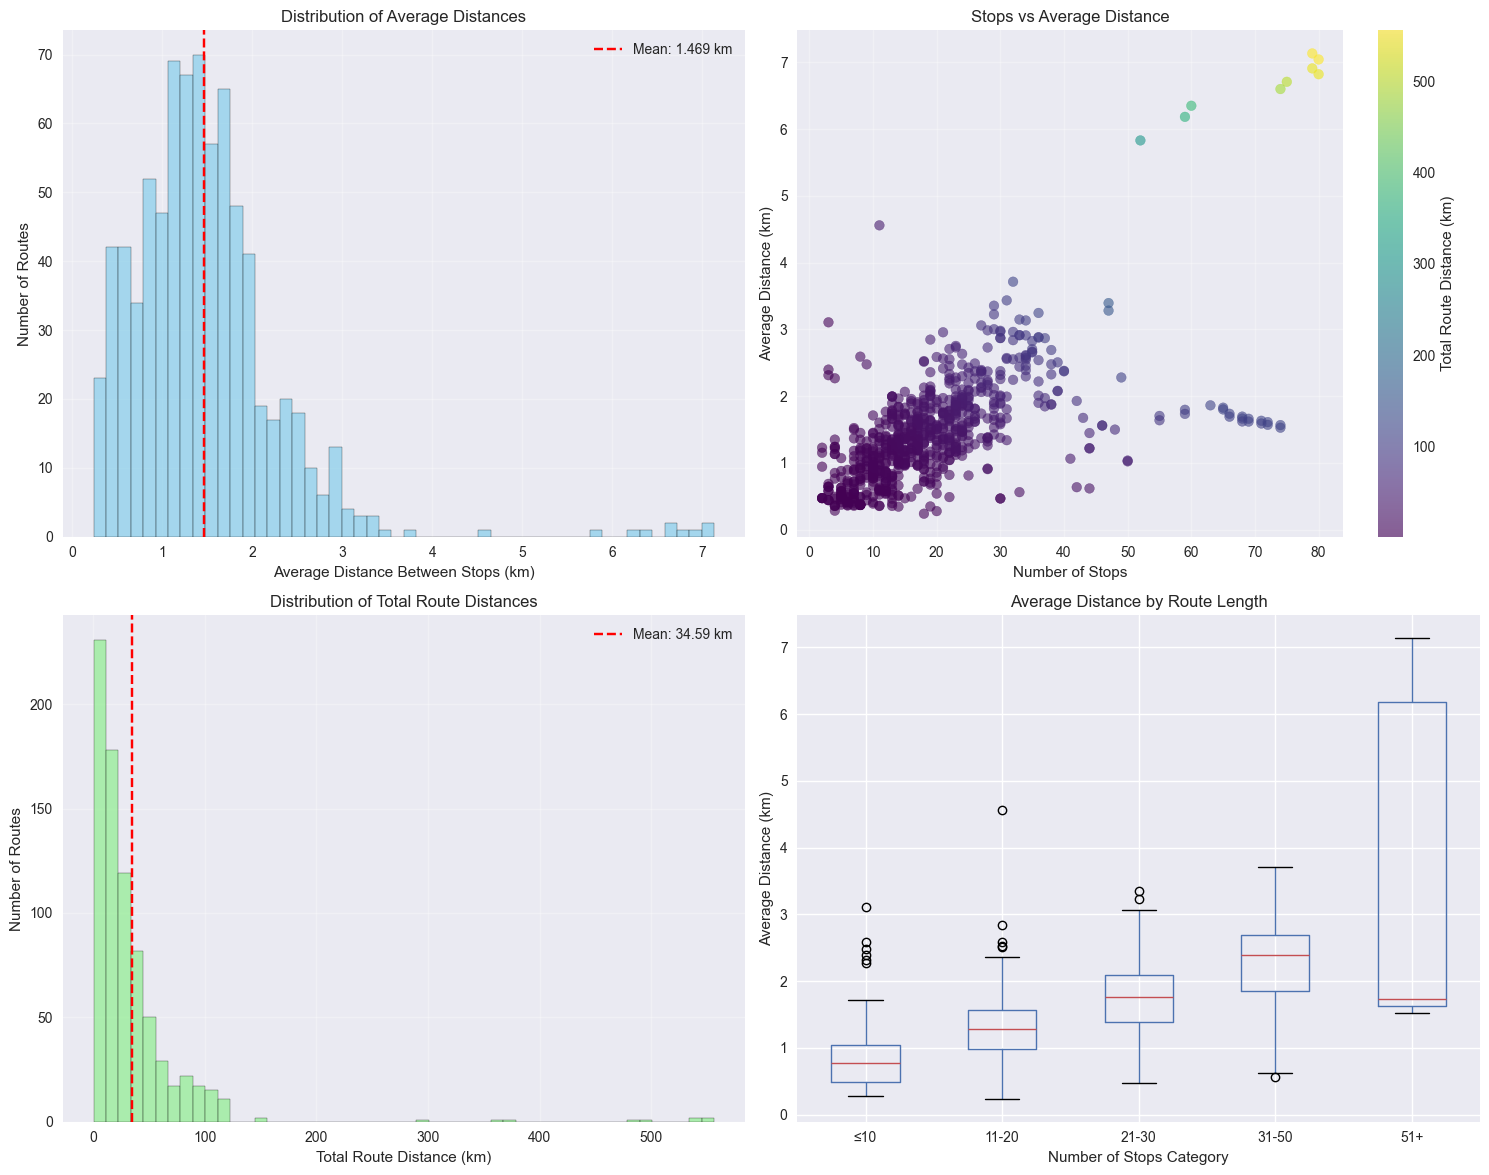

In [7]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Tokyo Bus Route Distance Analytics', fontsize=16, fontweight='bold')

# 1. Distribution of average distances
axes[0, 0].hist(df_routes['avg_distance'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(overall_avg_distance, color='red', linestyle='--', 
                  label=f'Mean: {overall_avg_distance:.3f} km')
axes[0, 0].set_xlabel('Average Distance Between Stops (km)')
axes[0, 0].set_ylabel('Number of Routes')
axes[0, 0].set_title('Distribution of Average Distances')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Number of stops vs average distance
scatter = axes[0, 1].scatter(df_routes['num_stops'], df_routes['avg_distance'], 
                            alpha=0.6, c=df_routes['total_distance'], cmap='viridis')
axes[0, 1].set_xlabel('Number of Stops')
axes[0, 1].set_ylabel('Average Distance (km)')
axes[0, 1].set_title('Stops vs Average Distance')
plt.colorbar(scatter, ax=axes[0, 1], label='Total Route Distance (km)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Distribution of total route distances
axes[1, 0].hist(df_routes['total_distance'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(df_routes['total_distance'].mean(), color='red', linestyle='--',
                  label=f'Mean: {df_routes["total_distance"].mean():.2f} km')
axes[1, 0].set_xlabel('Total Route Distance (km)')
axes[1, 0].set_ylabel('Number of Routes')
axes[1, 0].set_title('Distribution of Total Route Distances')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot of distances by route length categories
df_routes['stop_category'] = pd.cut(df_routes['num_stops'], 
                                   bins=[0, 10, 20, 30, 50, 100], 
                                   labels=['≤10', '11-20', '21-30', '31-50', '51+'])
df_routes.boxplot(column='avg_distance', by='stop_category', ax=axes[1, 1])
axes[1, 1].set_xlabel('Number of Stops Category')
axes[1, 1].set_ylabel('Average Distance (km)')
axes[1, 1].set_title('Average Distance by Route Length')
plt.suptitle('')  # Remove the automatic title from boxplot

plt.tight_layout()
plt.show()

## Top and Bottom Routes Analytics

In [8]:
# Top 10 routes with highest average distances
top_routes = df_routes.nlargest(10, 'avg_distance')[['route_name', 'route_name_ja', 'num_stops', 'avg_distance', 'total_distance']]
print("🔝 TOP 10 ROUTES (Highest average distance between stops):")
print(top_routes.to_string(index=False))

print("\n" + "="*80 + "\n")

# Bottom 10 routes with lowest average distances
bottom_routes = df_routes.nsmallest(10, 'avg_distance')[['route_name', 'route_name_ja', 'num_stops', 'avg_distance', 'total_distance']]
print("🔻 BOTTOM 10 ROUTES (Lowest average distance between stops):")
print(bottom_routes.to_string(index=False))

🔝 TOP 10 ROUTES (Highest average distance between stops):
route_name route_name_ja  num_stops  avg_distance  total_distance
     Ume70  梅７０ 花小金井駅北口行         79      7.134185      556.466449
     Ume70  梅７０ 花小金井駅北口行         80      7.043881      556.466571
     Ume70     梅７０ 青梅車庫行         79      6.909903      538.972401
     Ume70     梅７０ 青梅車庫行         80      6.822445      538.973138
     Ume70     梅７０ 小平駅前行         75      6.709122      496.475035
     Ume70     梅７０ 青梅車庫行         74      6.600496      481.836243
     Ume70   梅７０ 東大和市駅前行         60      6.350071      374.654167
     Ume70     梅７０ 青梅車庫行         59      6.183918      358.667234
     Ume70     梅７０ 青梅車庫行         52      5.830634      297.362315
 Chokkou03 直行０３ 日本科学未来館行         11      4.558291       45.582909


🔻 BOTTOM 10 ROUTES (Lowest average distance between stops):
route_name route_name_ja  num_stops  avg_distance  total_distance
   Ou40Hei    王４０丙 王子駅前行         18      0.236827        4.026058
      Ou55     王５５ 王子駅

## Interactive Plotly Visualizations


In [9]:
# Create interactive scatter plot with Japanese route names
fig_scatter = px.scatter(
    df_routes, 
    x='num_stops', 
    y='avg_distance',
    size='total_distance',
    color='avg_distance',
    hover_data=['route_name', 'route_name_ja', 'total_distance'],
    labels={
        'num_stops': 'Number of Stops',
        'avg_distance': 'Average Distance Between Stops (km)',
        'total_distance': 'Total Route Distance (km)'
    },
    title='Interactive: Route Analytics - Stops vs Average Distance',
    color_continuous_scale='viridis'
)

fig_scatter.update_layout(
    width=800,
    height=600,
    title_font_size=16
)

fig_scatter.show()

In [10]:
# Create interactive histogram
fig_hist = px.histogram(
    df_routes,
    x='avg_distance',
    nbins=50,
    title='Distribution of Average Distances Between Bus Stops',
    labels={'avg_distance': 'Average Distance (km)', 'count': 'Number of Routes'},
    color_discrete_sequence=['skyblue']
)

# Add mean line
fig_hist.add_vline(
    x=overall_avg_distance,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean: {overall_avg_distance:.3f} km"
)

fig_hist.update_layout(
    width=800,
    height=500,
    title_font_size=16
)

fig_hist.show()

In [11]:
# Create bar chart of top/bottom routes with Japanese names
top_10 = df_routes.nlargest(10, 'avg_distance')
bottom_10 = df_routes.nsmallest(10, 'avg_distance')

fig_bars = make_subplots(
    rows=1, cols=2,
    subplot_titles=["Top 10 Routes (Highest Avg Distance)", "Bottom 10 Routes (Lowest Avg Distance)"],
    horizontal_spacing=0.1
)

# Top routes
fig_bars.add_trace(
    go.Bar(
        x=top_10['avg_distance'],
        y=[f"{row['route_name']} ({row['route_name_ja']})" for _, row in top_10.iterrows()],
        orientation='h',
        name='Top Routes',
        marker_color='red',
        text=[f"{dist:.2f} km" for dist in top_10['avg_distance']],
        textposition='auto'
    ),
    row=1, col=1
)

# Bottom routes
fig_bars.add_trace(
    go.Bar(
        x=bottom_10['avg_distance'],
        y=[f"{row['route_name']} ({row['route_name_ja']})" for _, row in bottom_10.iterrows()],
        orientation='h',
        name='Bottom Routes',
        marker_color='green',
        text=[f"{dist:.3f} km" for dist in bottom_10['avg_distance']],
        textposition='auto'
    ),
    row=1, col=2
)

fig_bars.update_layout(
    title_text="Route Comparison: Highest vs Lowest Average Distances",
    title_font_size=16,
    height=600,
    showlegend=False
)

fig_bars.update_xaxes(title_text="Average Distance (km)")
fig_bars.update_yaxes(title_text="Route Name (Japanese)")

fig_bars.show()

## Geographic Visualization


In [12]:
# Create a map showing bus stop locations
# Calculate center of Tokyo
center_lat = df_stops['lat'].mean()
center_lng = df_stops['lng'].mean()

# Create base map
tokyo_map = folium.Map(
    location=[center_lat, center_lng],
    zoom_start=10,
    tiles='OpenStreetMap'
)

# Sample some bus stops to avoid overcrowding the map
sample_stops = df_stops.sample(n=min(500, len(df_stops)), random_state=42)

# Add bus stop markers
for _, stop in sample_stops.iterrows():
    folium.CircleMarker(
        location=[stop['lat'], stop['lng']],
        radius=3,
        popup=f"{stop['name_ja']}<br>Routes: {stop['num_routes']}",
        color='blue',
        fillColor='lightblue',
        fillOpacity=0.7
    ).add_to(tokyo_map)

# Add title
title_html = '''
             <h3 align="center" style="font-size:16px"><b>Tokyo Bus Stops Sample (500 random stops)</b></h3>
             '''
tokyo_map.get_root().html.add_child(folium.Element(title_html))

# Display map
tokyo_map

## Statistical Summary


In [13]:
# Comprehensive statistical summary
print("📊 COMPREHENSIVE STATISTICAL SUMMARY")
print("=" * 50)

print(f"\n🚌 Bus Stop Statistics:")
print(f"Total bus stop poles: {len(df_stops):,}")
print(f"Unique stop locations: {df_stops['name_ja'].nunique():,}")
print(f"Average routes per stop: {df_stops['num_routes'].mean():.2f}")

print(f"\n🛣️ Route Statistics:")
print(f"Total routes analyzed: {len(df_routes):,}")
print(f"Average stops per route: {df_routes['num_stops'].mean():.1f}")
print(f"Median stops per route: {df_routes['num_stops'].median():.1f}")

print(f"\n📏 Distance Statistics:")
print(f"Overall average distance: {overall_avg_distance:.3f} km")
print(f"Median average distance: {df_routes['avg_distance'].median():.3f} km")
print(f"Standard deviation: {df_routes['avg_distance'].std():.3f} km")
print(f"Total network distance: {total_network_distance:.2f} km")

print(f"\n🔍 Extreme Values:")
print(f"Longest average distance: {df_routes['avg_distance'].max():.3f} km ({df_routes.loc[df_routes['avg_distance'].idxmax(), 'route_name']})")
print(f"Shortest average distance: {df_routes['avg_distance'].min():.3f} km ({df_routes.loc[df_routes['avg_distance'].idxmin(), 'route_name']})")
print(f"Longest total route: {df_routes['total_distance'].max():.2f} km ({df_routes.loc[df_routes['total_distance'].idxmax(), 'route_name']})")
print(f"Most stops on route: {df_routes['num_stops'].max()} ({df_routes.loc[df_routes['num_stops'].idxmax(), 'route_name']})")

# Display detailed statistics
print(f"\n📈 Detailed Statistics:")
print(df_routes[['num_stops', 'avg_distance', 'total_distance']].describe())

📊 COMPREHENSIVE STATISTICAL SUMMARY

🚌 Bus Stop Statistics:
Total bus stop poles: 3,695
Unique stop locations: 1,673
Average routes per stop: 4.17

🛣️ Route Statistics:
Total routes analyzed: 782
Average stops per route: 19.7
Median stops per route: 17.0

📏 Distance Statistics:
Overall average distance: 1.469 km
Median average distance: 1.357 km
Standard deviation: 0.861 km
Total network distance: 27049.26 km

🔍 Extreme Values:
Longest average distance: 7.134 km (Ume70)
Shortest average distance: 0.237 km (Ou40Hei)
Longest total route: 556.47 km (Ume70)
Most stops on route: 80 (Ume70)

📈 Detailed Statistics:
        num_stops  avg_distance  total_distance
count  782.000000    782.000000      782.000000
mean    19.695652      1.468627       34.589840
std     13.149664      0.861328       54.967320
min      2.000000      0.236827        0.470225
25%     11.000000      0.940616        9.362743
50%     17.000000      1.357146       21.450341
75%     24.000000      1.812491       41.000777


## Export Results


In [14]:
# Save results to CSV files with Japanese route names
df_routes_export = df_routes[['route_name', 'route_name_ja', 'num_stops', 'avg_distance', 'total_distance']].copy()
df_routes_export.to_csv('tokyo_bus_route_analytics.csv', index=False)

df_stops_export = df_stops[['name_ja', 'name_en', 'lat', 'lng', 'num_routes']].copy()
df_stops_export.to_csv('tokyo_bus_stops.csv', index=False)

print("✅ Results exported to:")
print("   - tokyo_bus_route_analytics.csv (with Japanese route names)")
print("   - tokyo_bus_stops.csv")

# Create summary statistics dictionary
summary_stats = {
    'total_stops': len(df_stops),
    'unique_locations': df_stops['name_ja'].nunique(),
    'total_routes': len(df_routes),
    'overall_avg_distance_km': round(overall_avg_distance, 3),
    'total_network_distance_km': round(total_network_distance, 2),
    'longest_avg_distance_km': round(df_routes['avg_distance'].max(), 3),
    'shortest_avg_distance_km': round(df_routes['avg_distance'].min(), 3),
    'routes_with_japanese_names': sum(1 for _, row in df_routes.iterrows() if row['route_name_ja'])
}

with open('analytics_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print("   - analytics_summary.json (with Japanese route name count)")
print(f"\n🎉 Analytics complete! Total network covers {total_network_distance:.0f} km across {len(df_routes)} routes.")
print(f"📋 {summary_stats['routes_with_japanese_names']} routes have Japanese names available.")

✅ Results exported to:
   - tokyo_bus_route_analytics.csv (with Japanese route names)
   - tokyo_bus_stops.csv
   - analytics_summary.json (with Japanese route name count)

🎉 Analytics complete! Total network covers 27049 km across 782 routes.
📋 782 routes have Japanese names available.
